In [1]:
!pip install tensorflow==2.10.1


[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!python --version

Python 3.7.6


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm

from collections import Counter


In [5]:
captions_path = "Flickr8k_text/Flickr8k.token.txt"
images_directory = "Flicker8k_Dataset"

def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)

captions[:2]

['1000268201_693b08cb0e.jpg#1\ta girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg#2\ta little girl climbing into a wooden playhouse .\n']

In [6]:
import re

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)      # remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # clean extra spaces
    return text

cleaned_captions = []

for line in captions:
    if '\t' in line:
        try:
            caption_text = line.strip().split('\t')[1]
            cleaned = clean_text(caption_text)
            cleaned_captions.append(cleaned)
        except Exception as e:
            print(f"Error processing line: {line} - {e}")


In [7]:
cleaned_captions[:1]

['a girl going into a wooden building']

In [8]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    image_id = captions[i].split('\t')[0].split('#')[0]
    item = image_id + '\t' + 'start ' + cleaned_captions[i] + ' end\n'
    captions_IDs.append(item)

captions_IDs[:20]

['1000268201_693b08cb0e.jpg\tstart a girl going into a wooden building end\n',
 '1000268201_693b08cb0e.jpg\tstart a little girl climbing into a wooden playhouse end\n',
 '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
 '1000268201_693b08cb0e.jpg\tstart a little girl in a pink dress going into a wooden cabin end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
 '1001773457_577c3a7d70.jpg\tstart a black dog and a white dog with brown spots are staring at each other in the street end\n',
 '1001773457_577c3a7d70.jpg\tstart two dogs of different breeds looking at each other on the road end\n',
 '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
 '1002674143_1b742ab4b8.jpg\tstart a little girl covered in paint sits in front of a painted rainbow with her hands i

In [9]:
def visualaization(data, num_of_images):
    captions_dictionary = {}
    for item in data:
        image_id, caption = item.strip().split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)

    # Limit to requested number of images
    selected_items = list(captions_dictionary.items())[:num_of_images]

    fig = plt.figure(figsize=(10, num_of_images * 3))
    count = 1
    for filename, captions in selected_items:
        image_path = os.path.join(images_directory, filename)
        try:
            image_load = load_img(image_path, target_size=(199, 199))
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            continue

        # Image subplot
        ax = fig.add_subplot(num_of_images, 2, count)
        ax.imshow(image_load)
        ax.set_xticks([])
        ax.set_yticks([])
        count += 1

        # Caption subplot
        ax = fig.add_subplot(num_of_images, 2, count)
        ax.axis('off')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(captions))
        for i, caption in enumerate(captions):
            ax.text(0, len(captions) - i - 1, caption, fontsize=10)
        count += 1

        # Stop if we've filled all subplots
        if count > num_of_images * 2:
            break

    plt.tight_layout()
    plt.show()


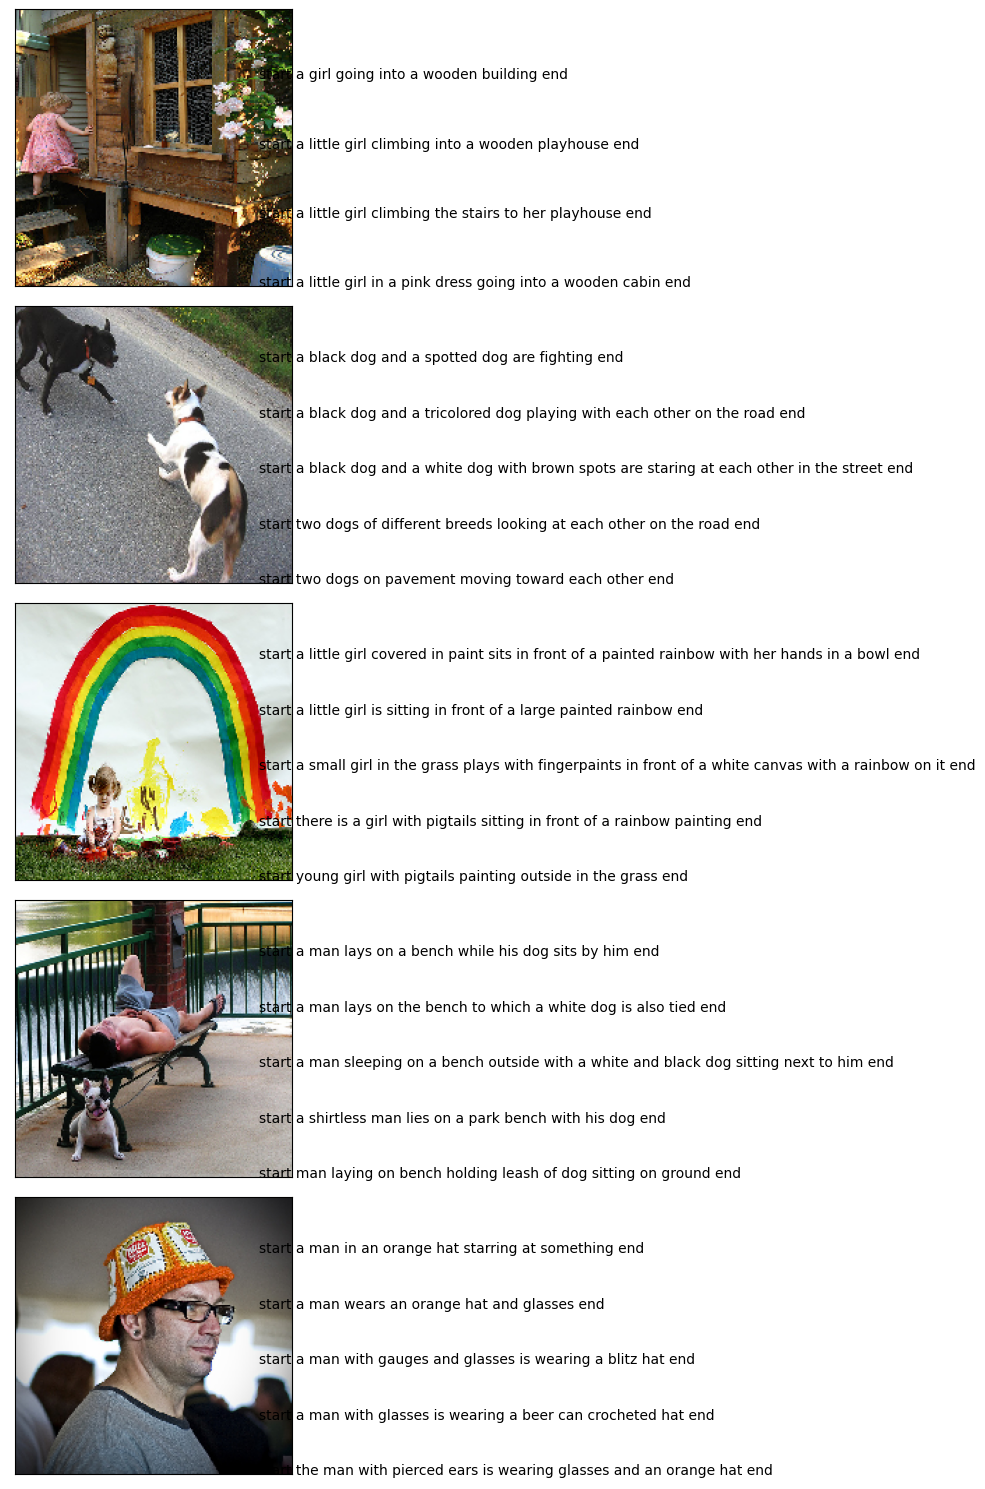

In [10]:
visualaization(captions_IDs, 5)


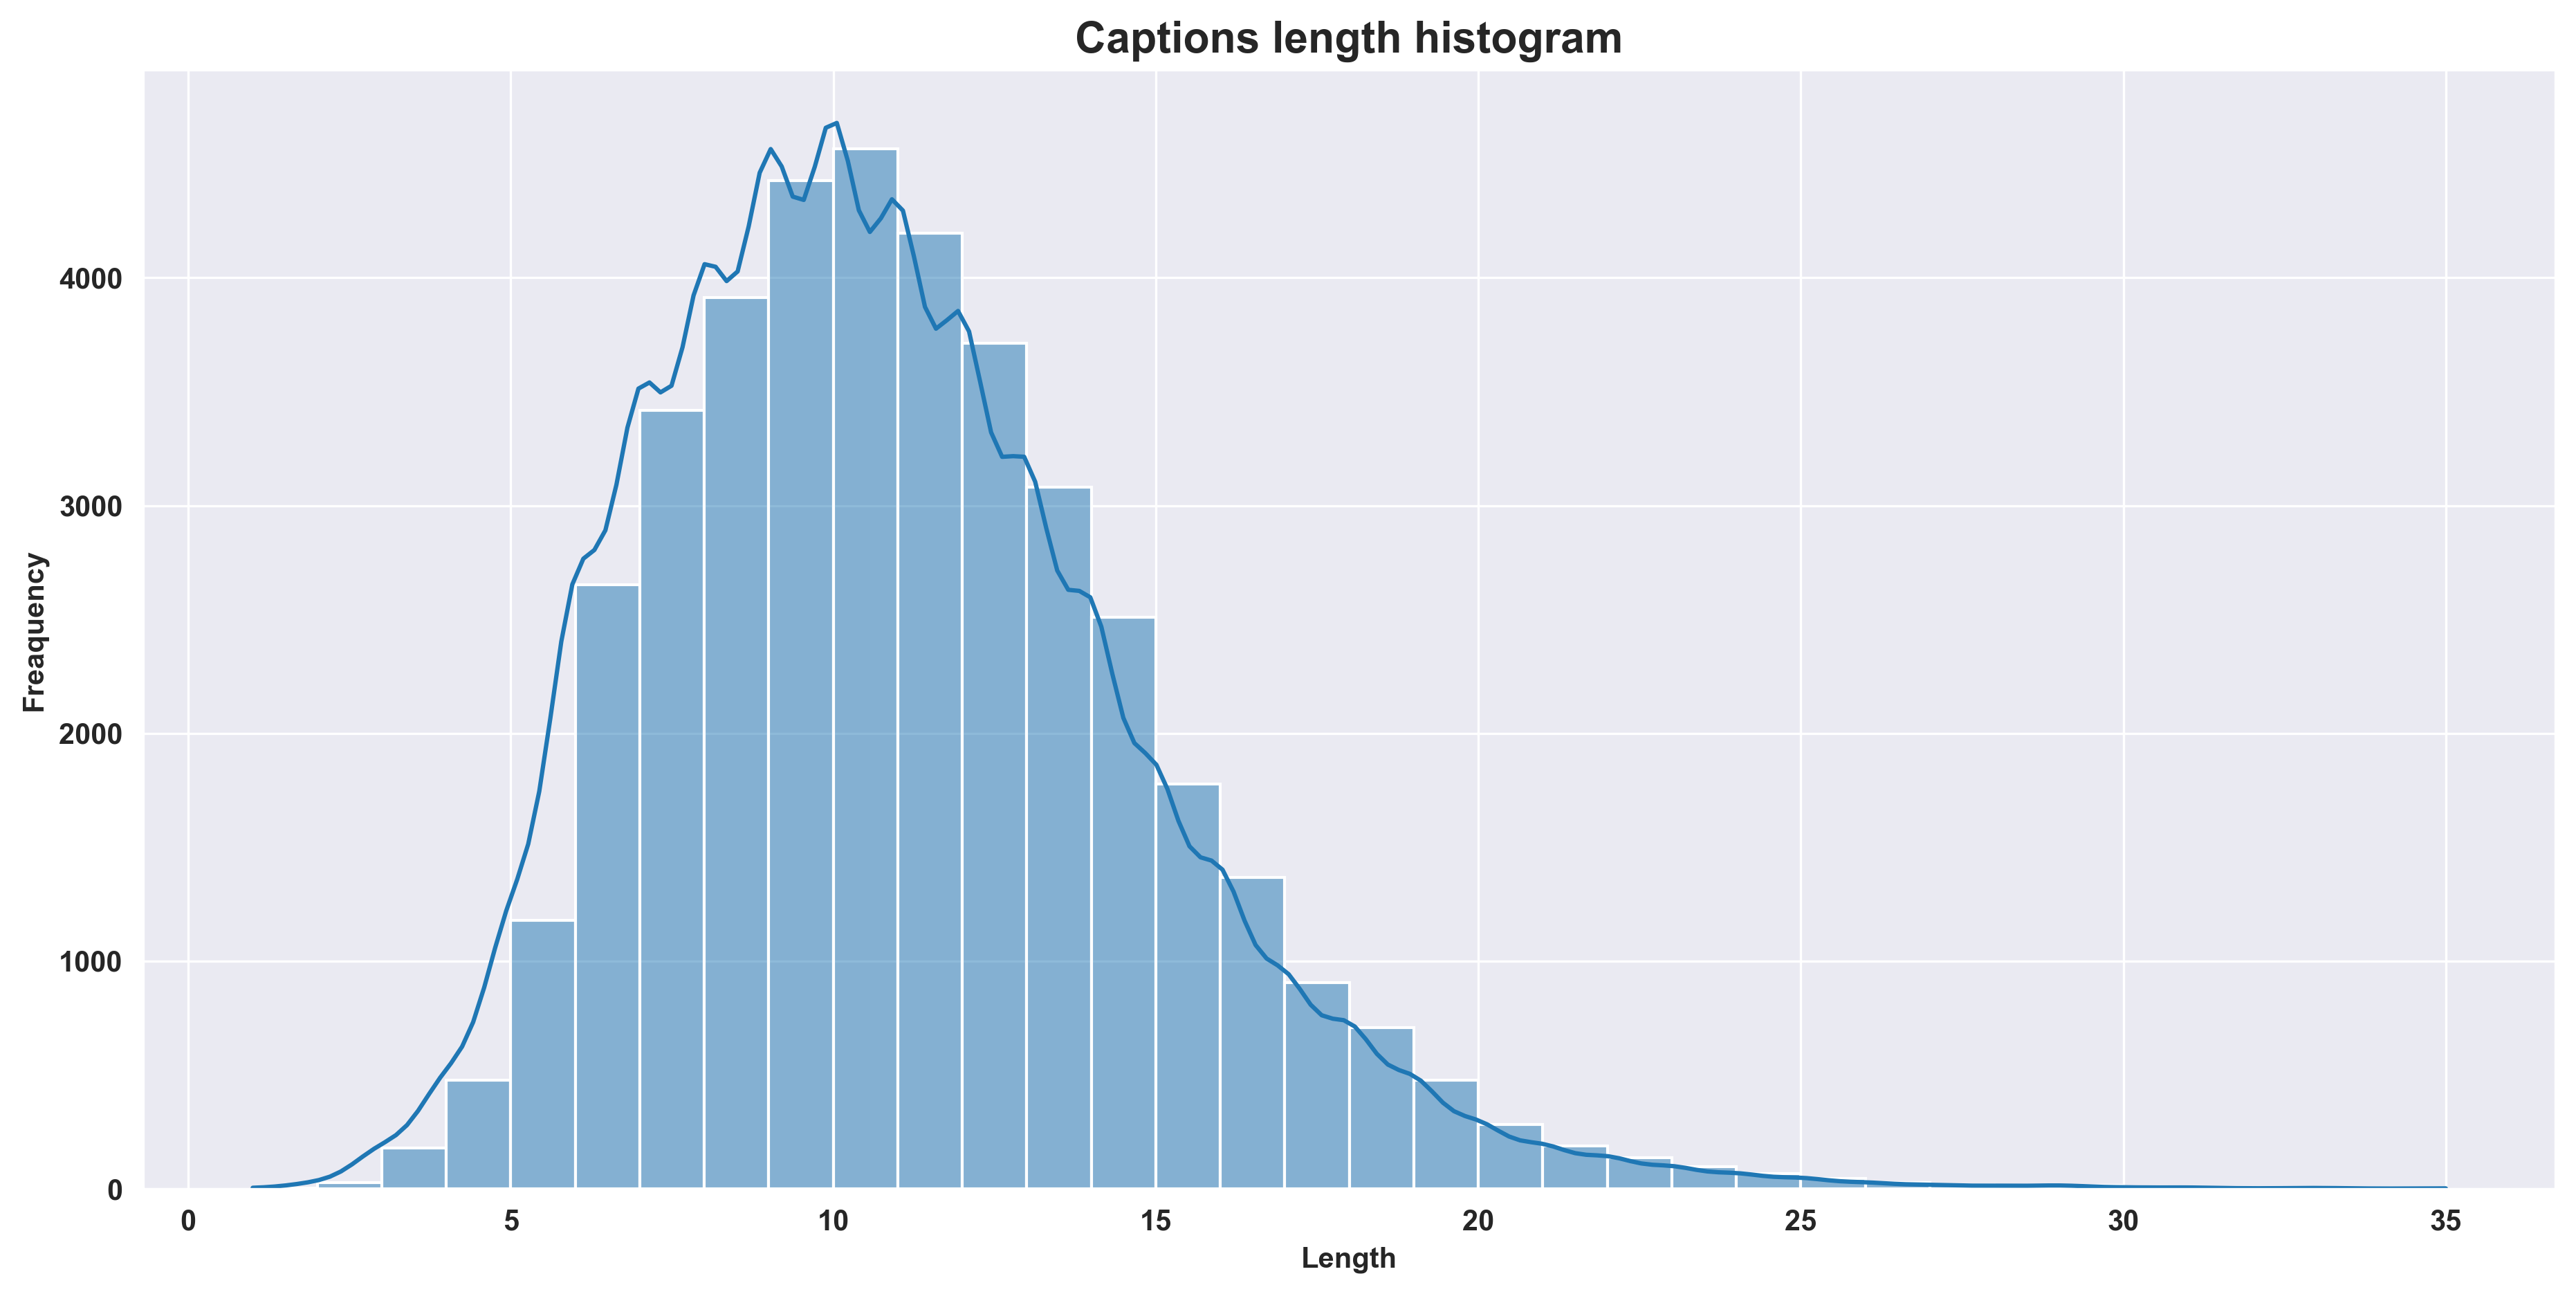

In [11]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)

In [12]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [ ]:

all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    image_id = image_id.split('#')[0]  # Fix: remove caption index

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print(f'Unknown image ID: {image_id}')

# Show first example from each set and image counts (divide by 5 for unique images)
print(train_captions[0])
print(val_captions[0])
print(test_captions[0])
print("Train Images:", len(train_captions) / 5)
print("Val Images:", len(val_captions) / 5)
print("Test Images:", len(test_captions) / 5)


Unknown image ID: 2258277193_586949ec62.jpg.1
Unknown image ID: 2258277193_586949ec62.jpg.1
Unknown image ID: 2258277193_586949ec62.jpg.1
Unknown image ID: 2258277193_586949ec62.jpg.1
Unknown image ID: 2258277193_586949ec62.jpg.1
1000268201_693b08cb0e.jpg	start a girl going into a wooden building end

1022454428_b6b660a67b.jpg	start a couple and an infant being held by the male sitting next to a pond with a near by stroller end

1042590306_95dea0916c.jpg	start a man and woman pose for the camera while another man looks on end

Train Images: 6876.8
Val Images: 1092.0
Test Images: 122.0


In [ ]:


def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Load model without top classification layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
model = Model(inputs=base_model.input, outputs=tf.keras.layers.GlobalAveragePooling2D()(base_model.output))


In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

train_image_features, val_image_features, test_image_features = {}, {}, {}

pbar = tqdm(total=len(all_image_ids), position=0, leave=True, colour='green')

for image_id in all_image_ids:  # This is just the filename, e.g. '1000268201_693b08cb0e.jpg'
    image_path = os.path.join(images_directory, image_id)

    try:
        image_features = extract_image_features(model, image_path)  # Use the fixed model
        image_features = image_features.flatten()

        if image_id in train_image_ids:
            train_image_features[image_id] = image_features
        elif image_id in val_image_ids:
            val_image_features[image_id] = image_features
        elif image_id in test_image_ids:
            test_image_features[image_id] = image_features
        else:
            print(f'Unknown image ID: {image_id}')
    except Exception as e:
        print(f"Error processing {image_id}: {e}")
    
    pbar.update(1)

pbar.close()


100%|██████████| 8091/8091 [30:27<00:00,  4.43it/s]


In [ ]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield [np.array(X_images), np.array(X_captions)], np.array(y)


max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

cnn_output_dim = inception_v3_model.output_shape[1] # 2048

batch_size_train = 270
batch_size_val = 150

train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [ ]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Features_Input (InputLayer)    [(None, 2048)]       0           []                               
                                                                                                  
 batch_normalization_472 (Batch  (None, 2048)        8192        ['Features_Input[0][0]']         
 Normalization)                                                                                   
                                                                                                  
 Sequence_Input (InputLayer)    [(None, 36)]         0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 256)          524544      ['batch_normalizat

In [ ]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

caption_model.save("caption_model.h5")  


Epoch 1/15
127/127 [==============================] - 1025s 8s/step - loss: 4.5787 - val_loss: 3.7886 - lr: 0.0055
Epoch 2/15
127/127 [==============================] - 814s 6s/step - loss: 3.3269 - val_loss: 3.3856 - lr: 0.0030
Epoch 3/15
127/127 [==============================] - 809s 6s/step - loss: 2.9304 - val_loss: 3.2693 - lr: 0.0017
Epoch 4/15
127/127 [==============================] - 822s 6s/step - loss: 2.7098 - val_loss: 3.2423 - lr: 9.0718e-04
Epoch 5/15
127/127 [==============================] - 813s 6s/step - loss: 2.5754 - val_loss: 3.2398 - lr: 4.9787e-04
Epoch 6/15
127/127 [==============================] - 814s 6s/step - loss: 2.4917 - val_loss: 3.2395 - lr: 2.7324e-04
Epoch 7/15
127/127 [==============================] - 811s 6s/step - loss: 2.4425 - val_loss: 3.2427 - lr: 1.4996e-04
Epoch 8/15
127/127 [==============================] - 825s 6s/step - loss: 2.4126 - val_loss: 3.2459 - lr: 8.2297e-05
Epoch 9/15
127/127 [==============================] - 819s 6s/step 

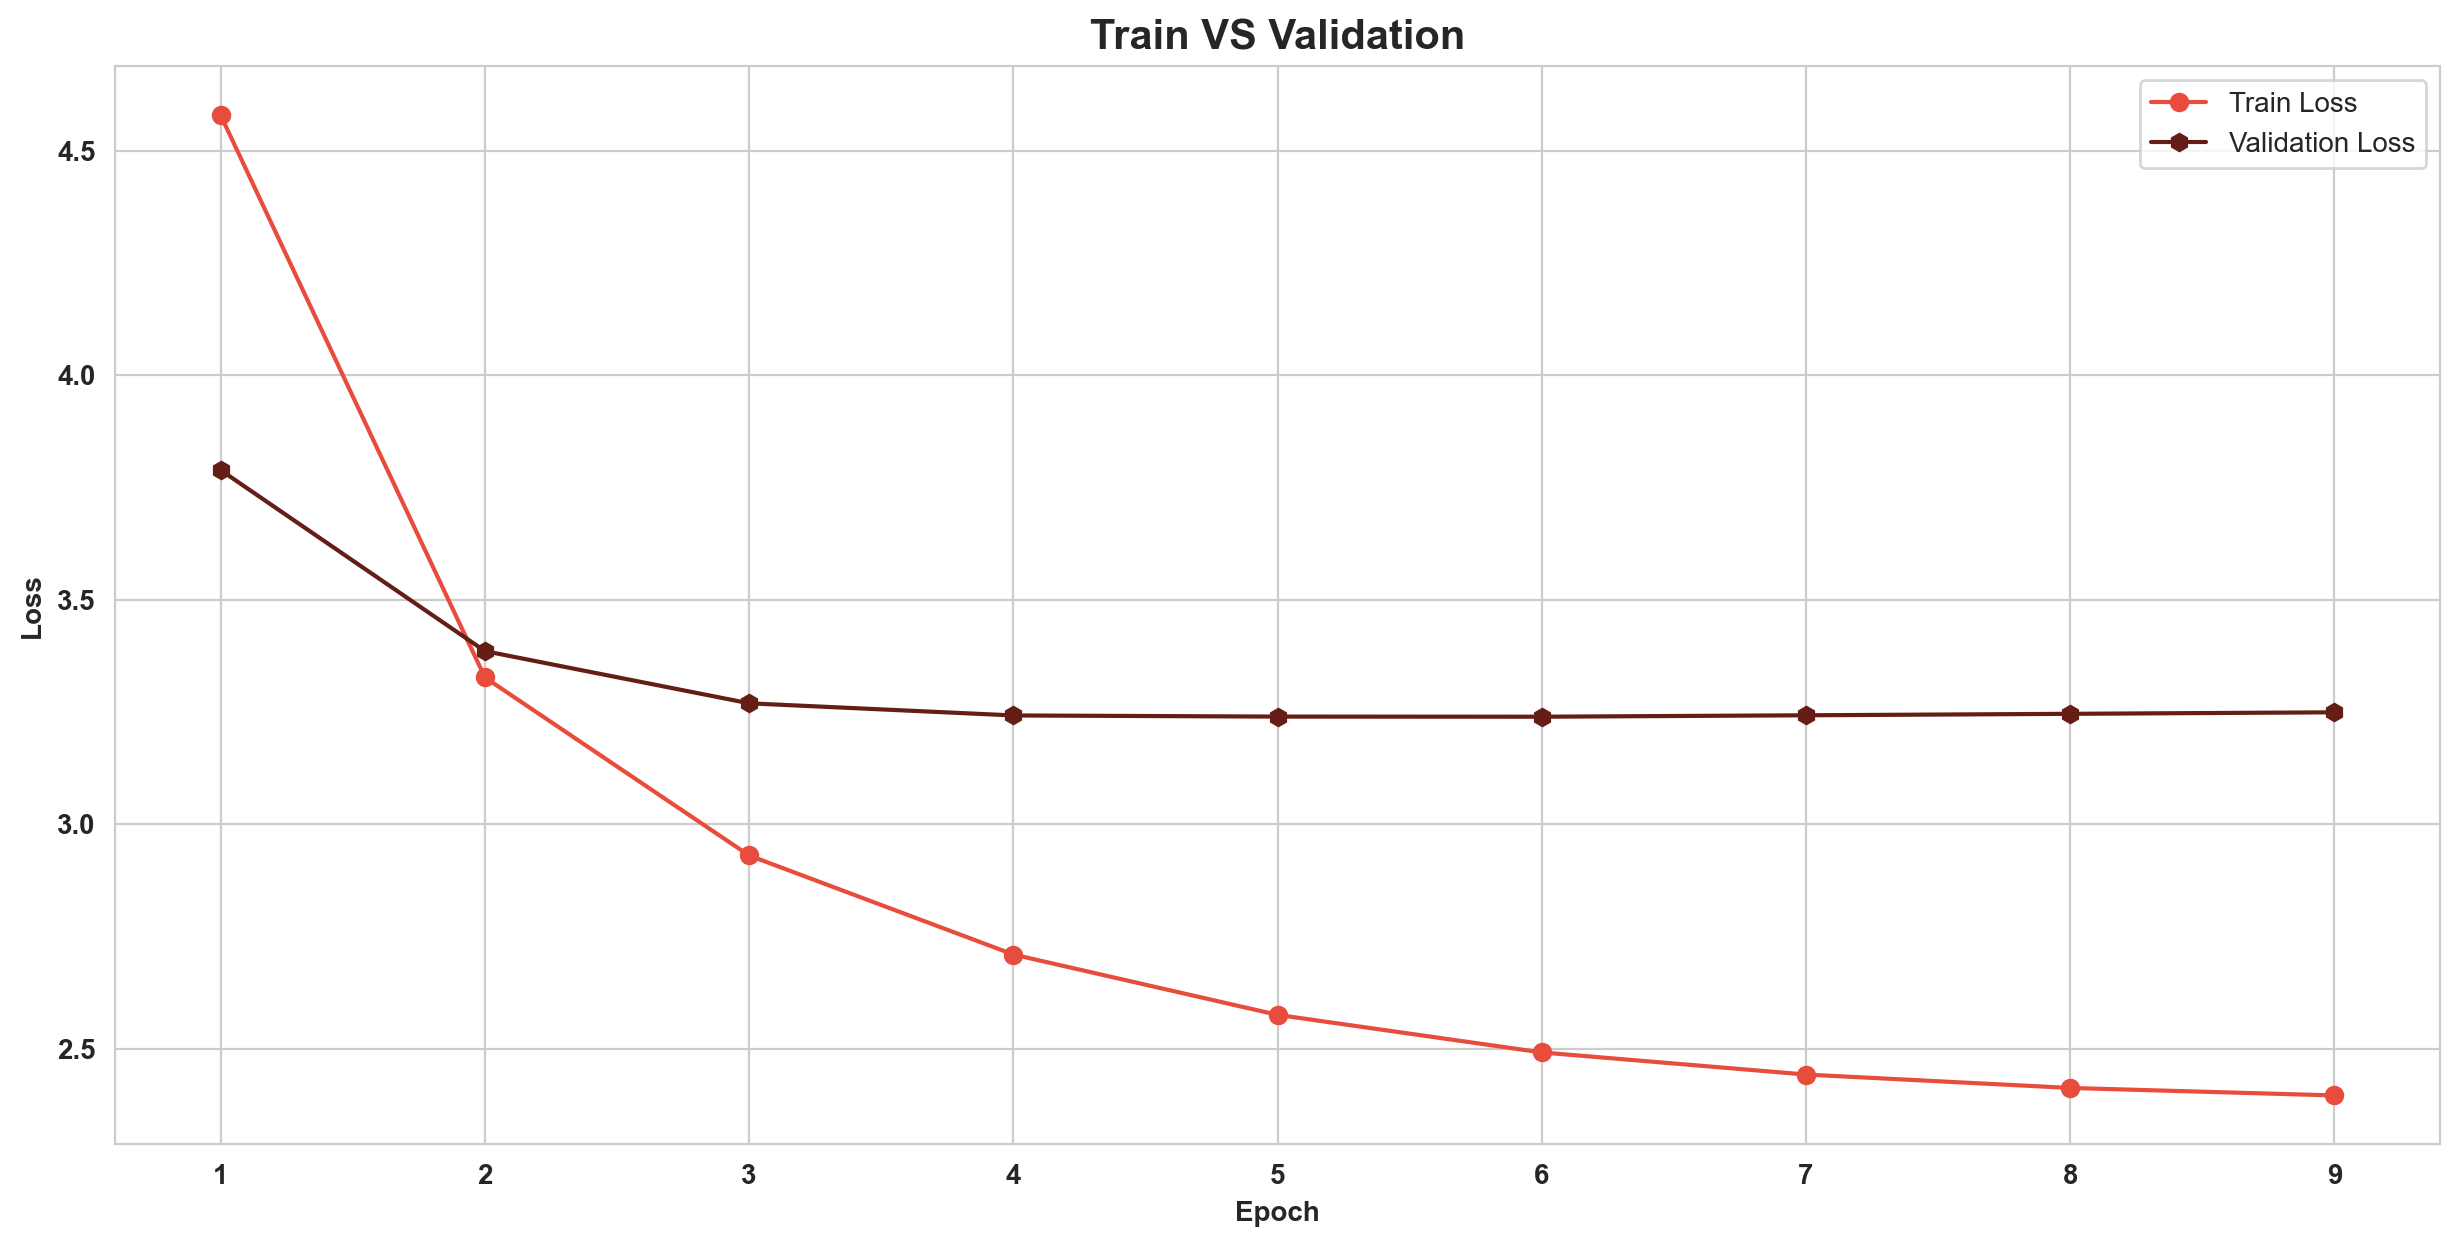

In [ ]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [ ]:
def greedy_generator(image_features):
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        in_text += ' ' + word
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

In [ ]:
generated_captions = {}

pbar = tqdm(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)

pbar.close()

100%|██████████| 122/122 [02:44<00:00,  1.35s/it]


In [ ]:
def visualize_generated_captions(greedy_caps_dict, num_of_images, images_directory):
    image_ids = list(greedy_caps_dict.keys())
    selected_images = np.random.choice(image_ids, size=num_of_images, replace=False)

    plt.figure(figsize=(12, num_of_images * 4))
    
    for i, image_id in enumerate(selected_images):
        caption = greedy_caps_dict[image_id]
        img = load_img(images_directory + image_id, target_size=(199, 199))
        
        ax = plt.subplot(num_of_images, 1, i + 1)
        ax.imshow(img)
        ax.set_title(f'Caption: {caption}', fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


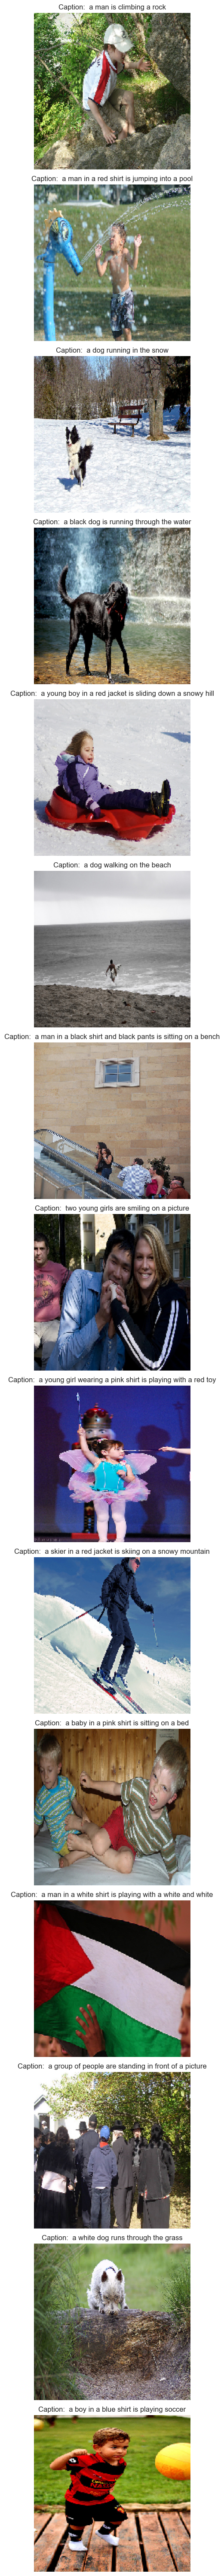

In [ ]:
visualize_generated_captions(generated_captions, num_of_images=15, images_directory='./Flicker8k_Dataset/')
